# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> MCD3100 - Ciencia de Datos Geoespaciales
**Pontificia Universidad Católica de Chile**<br>
**Magister en Ciencia de Datos**<br>


Este tutorial tiene como objetivos:
- Conocer la librería `rasterio`y utilizarla para leer, inspeccionar y visualizar datos raster.
- Familiarizarse con imágenes RGB y modelos digitales de elevación.
- Samplear valores de un raster en ubicaciones geográficas específicas.



## 1. Datos raster multibanda y unibanda.

Los sistemas de información geográfica utilizan GeoTIFF y otros formatos para organizar y almacenar conjuntos de datos ráster en cuadrícula, como imágenes satelitales y modelos de terreno. `rasterio` lee y escribe estos formatos y proporciona una API de Python basada en matrices N-dimensionales de Numpy y GeoJSON (https://rasterio.readthedocs.io/en/stable/index.html).

Primero, utilizaremos la librería `rasterio`para leer un archivo raster correspondiente a una imagen de dron de una zona de la ciudad de Viña del Mar. El dron captura una secuencia de imágenes a lo largo de su vuelo, que luego son procesadas con un software especializado para generar una única imagen compuesta y [ortorectificada](https://www.esri.com/about/newsroom/insider/what-is-orthorectified-imagery), es decir, una imagen en la cual se han corregido las distorsiones ópticas del sistema de sensores y los cambios aparentes en la posición de los objetos terrestres causados por el ángulo de visión del sensor.

La imagen es entregada en formato `.tif`. Para leerla, se utiliza el  método [open()](https://rasterio.readthedocs.io/en/stable/topics/reading.html):


In [4]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#multibanda
ortho=rasterio.open('orthoMosaic_1m_VinadelMar_2023.tif')

Podemos revisar las características de la imagen, como su proyección, ancho, alto, y límites geográficos:

In [ ]:
# Proyeccion
ortho.crs

In [ ]:
# Dimensiones
print('Ancho, alto:',ortho.width,ortho.height)

# Nº de bandas
print('N bandas:',ortho.count)

In [ ]:
# Límites (bounding box)
ortho.bounds

In [ ]:
#Toda la metadata
ortho.meta

#### ¿Cuál es la distribución de valores de cada banda?

Para entender la distribución de los datos dentro de cada capa raster, podemos recurrir a la función `rasterio.show.plot_hist()`:

In [ ]:
from rasterio.plot import show_hist
fig,ax=plt.subplots(1,1,figsize=(6,4))

show_hist(ortho, bins=50,  stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=ax);


### 1.1 Visualización unibanda y RGB.

Un raster puede contener varias capas o bandas, correspondientes por ejemplo a distintas frecuencias o ventanas de observación. Las imágenes RGB, o de "pseudocolor" se forman a partir del stacking o combinación de tres colores: rojo, verde y azul

Cada banda de la imagen puede leerse y graficarse como una imagen separada, usando la función [show()](https://rasterio.readthedocs.io/en/latest/topics/plotting.html). También es posible visualizar las bandas RGB combinadas en una única imagen de pseudocolor.



Para visualizar bandas individuales o la imagen RGB: https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.show

In [ ]:
from rasterio.plot import show

# Leer y graficar cada banda por separado:
band = ortho.read(1)

# La imagen se guarda con un arreglo de numpy
print(type(band), band.shape)

# Tipo de datos de la imagen
print(band.dtype)

#Mostrar la imagen
show(band,cmap='Reds',transform=ortho.transform);

In [ ]:
fig,axes=plt.subplots(figsize=(10,4),nrows=1,ncols=3)
show((ortho, 1), cmap='Reds', title='Red Channel',ax=axes[0])
show((ortho, 2), cmap='Greens', title='Green Channel',ax=axes[1])
show((ortho, 3), cmap='Blues', title='Blue Channel',ax=axes[2]);

#### Visualización RGB.

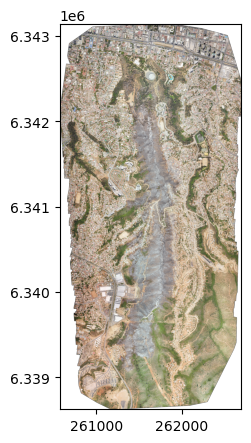

In [19]:
from rasterio.plot import show 

fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)

show(ortho.read(),ax=ax, transform=ortho.transform);

### 1.2 Imagen multibanda de Sentinel 2

Ahora probaremos con una imagen del satélite Sentinel 2, previamente descargada de Google Earth Engine.


In [5]:
import rasterio
src=rasterio.open('20221219T143731_20221219T144224_T19HBD.tif') 
#src=rasterio.open('S2_2024_camp450_median.tif')

In [6]:
src.count

3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1012..11800].


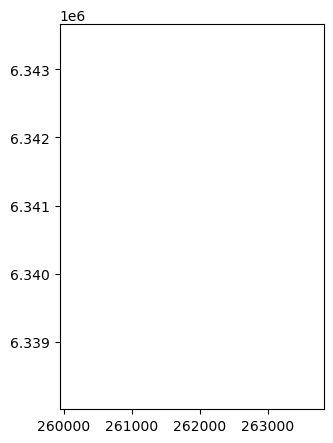

In [20]:
from rasterio.plot import show 

fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)

show(src.read(),ax=ax, transform=src.transform);

**¿Qué valores contiene cada raster?**

Para entender la distribución de los datos dentro de cada capa raster, podemos recurrir a la función `rasterio.show.plot_hist()`:

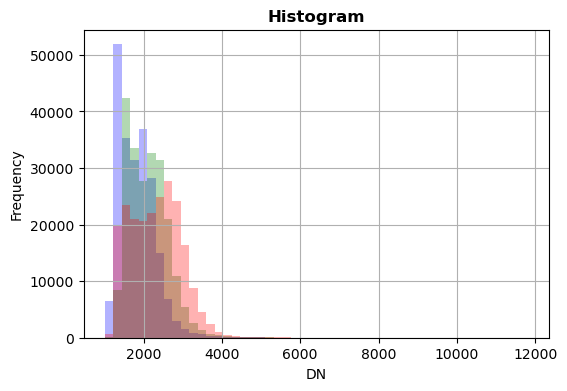

In [7]:
from rasterio.plot import show_hist
fig,ax=plt.subplots(1,1,figsize=(6,4))

show_hist(src, bins=50,  stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=ax);
ax.get_legend().remove();


En el **caso particular de las imágenes de Sentinel 2** BOA (level 2), los valores corresponden a la reflectancia multiplicada por un factor 10000, de acuerdo a lo indicado en la [documentación de GEE:](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED?hl=es-419)

*Los recursos incluyen 12 bandas espectrales UINT16 que representan el SR escalado en 10,000 (a diferencia de los datos de nivel 1, no hay una banda B10). También hay varias bandas más específicas de L2 (consulta la lista de bandas para obtener más detalles).*

#### ¿Cómo mejoramos el brillo y contraste de la imagen para una mejor visualización RGB?

Para ajustar las características de visualización de la imagen, podemos jugar con los parámetros de brillo y normalización de cada banda de acuerdo a [estos métodos](https://www.satmapper.hu/en/rgb-images/).


In [28]:
def brighten(band):
    alpha=0.05
    beta=0
    return np.clip(alpha*band+beta, 0,255) # los valores quedan truncados entre 0 y 255

# Normalización min-max para filtrar outliers
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)


In [29]:
# Read the grid values into numpy arrays
red = src.read(1)
green = src.read(2)
blue = src.read(3)

red=brighten(red)
green=brighten(green)
blue=brighten(blue)


# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

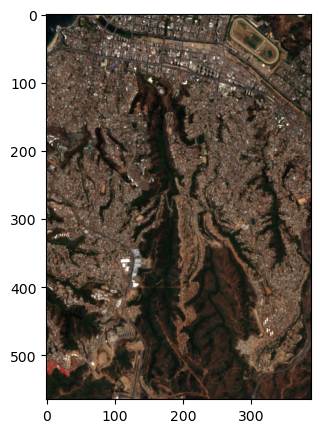

In [30]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))
fig=plt.figure(figsize=(5,5))
plt.imshow(rgb);

## 2. Modelo Digital de Elevación. 

Un modelo digital de elevación (DEM) es una representación de la superficie topográfica del suelo desnudo (tierra desnuda) de la Tierra, excluyendo árboles, edificios y cualquier otro objeto de la superficie. 

Los DEM se pueden generar a partir de distintas fuentes, como sensores LIDAR o misiones de radar. Una fuente utilizada globalmente es eel conjunto de datos de elevación digital de la Misión Topográfica con Radar del Transbordador (SRTM), que se produjo originalmente para proporcionar datos de elevación coherentes y de alta calidad con un alcance casi global. 

Puede encontrar más información de esta misión acá: 

https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1

A continuación estudiaremos como ejemplo un DEM previamente descargado para una región de Chile central:

In [ ]:
src_dem=rasterio.open('s34_w072_1arc_v3.tif') 
dem = src_dem.read()
dem

In [ ]:
# View the Coordinate Reference System (CRS) & spatial extent
print("The CRS for this data is:", src_dem.crs)
print("The spatial extent is:", src_dem.bounds)

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(figsize=(5,5))
ax_divider = make_axes_locatable(ax)
#agregar eje para la barra de color
cax = ax_divider.append_axes("right", size="7%", pad="2%")


im=show(src_dem, transform=src_dem.transform,cmap='terrain',ax=ax)
cb = im.get_images()[0]

fig.colorbar(cb, ax=ax,cax=cax);

### 2.1 Samplear el DEM en los puntos de interés.

Para cualquier raster, podemos extraer el valor del pixel correspondiente a una ubicación geográfica de interés. En este ejemplo, obtendremos el valor de la elevación en un conjunto de posiciones aleatorias. Alternativamente, podría tener una lista o (Geo)DataFrame de puntos a evaluar.

Para esto, utilizaremos la función `rasterio.sample`: https://rasterio.readthedocs.io/en/stable/api/rasterio.sample.html

In [ ]:
import random 

#puntos aleatorios
x=random.choices(np.arange(-72,-71,0.01), k=10)
y=random.choices(np.arange(-34,-33,0.01), k=10)
coords = np.array([[x,y] for x,y in zip(x,y)])


In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(figsize=(5,5))
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")


im=show(src_dem, transform=src_dem.transform,cmap='terrain',ax=ax)
cb = im.get_images()[0]
fig.colorbar(cb, ax=ax,cax=cax)

ax.plot(coords[:,0],coords[:,1],marker='o',color='red',ls='None')
bounds=src_dem.bounds
ax.set_xlim(bounds[0],bounds[2])
ax.set_ylim(bounds[1],bounds[3]);

In [ ]:
elevations=pd.DataFrame(data=coords,columns=['lon','lat'])
elevations

In [ ]:
elevations['z_m'] = [x[0] for x in src_dem.sample(coords)]

elevations

¿Cuál es la elevación promedio, máxima y mínima de esta región?

In [ ]:
dem.mean(),dem.min(),dem.max()  #metros

In [ ]:
dem_km=dem/1000

In [ ]:
dem_km.mean(),dem_km.min(),dem_km.max()